In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.image import resize
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [2]:
#Loading Model
model = tf.keras.models.load_model("Trained_model.keras")

In [3]:
# classes = ['blues', 'classical','country','disco','hiphop','metal','pop','reggae','rock']
classes = ['hiphop','metal', 'rock']

In [4]:
# Load and preprocess audio data
def load_and_preprocess_data(file_path, target_shape=(150, 150)):
    data = []
    audio_data, sample_rate = librosa.load(file_path, sr=None)
    # Perform preprocessing
    # Define the duration of each chunk and overlap
    chunk_duration = 4  # seconds
    overlap_duration = 2  # seconds
                
    # Convert durations to samples
    chunk_samples = chunk_duration * sample_rate
    overlap_samples = overlap_duration * sample_rate
                
    # Calculate the number of chunks
    num_chunks = int(np.ceil((len(audio_data) - chunk_samples) / (chunk_samples - overlap_samples))) + 1
                
    # Iterate over each chunk
    for i in range(num_chunks):
                    # Calculate start and end indices of the chunk
        start = i * (chunk_samples - overlap_samples)
        end = start + chunk_samples
                    
                    # Extract the chunk of audio
        chunk = audio_data[start:end]
                    
                    # Compute the Mel spectrogram for the chunk
        mel_spectrogram = librosa.feature.melspectrogram(y=chunk, sr=sample_rate)
                    
                #mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
        data.append(mel_spectrogram)
    
    return np.array(data)

In [5]:
file_path = 'Mobb Deep - Shook Ones, Pt. II (Official Audio).mp3'
X_test = load_and_preprocess_data(file_path)

In [6]:
X_test.shape

(163, 150, 150, 1)

In [7]:
def model_prediction(X_test):
    Y_pred = model.predict(X_test)
    predicted_categories = np.argmax(Y_pred, axis=1)
    unique_elements, counts = np.unique(predicted_categories, return_counts=True)
    max_count = np.max(counts)
    max_elements = unique_elements[counts==max_count]
    return max_elements[0]

In [8]:
c_index = model_prediction(X_test)

6/6 [==============================] - 1s 177ms/step


In [9]:
c_index

0

In [10]:
print("Predicted genre : ", classes[c_index])

Predicted genre :  hiphop


In [ ]:
# Create database focused on the 3 genres used
def create_gtzan_database(base_path="genres_original_split"):
    database = []
    
    for genre in ['hiphop', 'metal', 'rock']:
        genre_path = os.path.join(base_path, genre)
        
        if not os.path.isdir(genre_path):
            print(f"Warning: Genre directory {genre} not found in {base_path}")
            continue
            
        print(f"Processing genre: {genre}")
        
        for file in os.listdir(genre_path):
            if file.endswith('.wav') or file.endswith('.au'):
                file_path = os.path.join(genre_path, file)
                
                try:
                    # Load audio
                    y, sr = librosa.load(file_path, sr=22050, duration=30)
                    
                    # Extract simpler feature set
                    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
                    mfcc_means = np.mean(mfccs, axis=1)  # Average over time
                    
                    database.append({
                        'file': file,
                        'path': file_path,
                        'genre': genre,
                        'features': mfcc_means.tolist()
                    })
                    
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")
                    continue
    
    return pd.DataFrame(database)

In [ ]:
database = create_gtzan_database()

# Saving database for future use
database.to_csv("gtzan_features_database.csv", index=False)
print(f"Database created with {len(database)} songs")

In [11]:
def recommend_similar_songs(query_song_path, database_path="gtzan_features_database.csv", top_n=5):
    # Load the database
    database = pd.read_csv(database_path)
    database['features'] = database['features'].apply(eval)  # Convert string back to list
    
    # Predict the genre using your existing model
    X_test = load_and_preprocess_data(query_song_path)
    genre_index = model_prediction(X_test)
    predicted_genre = classes[genre_index]
    print(f"Predicted genre: {predicted_genre}")
    
    # Extract features from the query song for similarity comparison
    try:
        y, sr = librosa.load(query_song_path, sr=22050, duration=30)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        query_features = np.mean(mfccs, axis=1)  # Average over time
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None
    
    # Filter database to only include songs from the predicted genre
    genre_songs = database[database['genre'] == predicted_genre].copy()
    
    if len(genre_songs) == 0:
        return f"No songs found in the predicted genre: {predicted_genre}"
    
    # Extract features for scaling
    all_features = np.array(genre_songs['features'].tolist())
    
    # Apply scaling to features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(all_features)
    
    # Scale query features
    scaled_query_features = scaler.transform([query_features])[0]
    
    # Calculate cosine similarity with scaled features
    similarities = []
    for _, song in genre_songs.iterrows():
        song_features = np.array(song['features'])
        scaled_song_features = scaler.transform([song_features])[0]
        sim = cosine_similarity([scaled_query_features], [scaled_song_features])[0][0]
        similarities.append(sim)
    
    genre_songs['similarity'] = similarities
    
    # Sort by similarity and return top recommendations
    recommendations = genre_songs.sort_values('similarity', ascending=False).head(top_n)
    return recommendations[['file', 'genre', 'similarity']]

In [12]:
def recommend_songs_knn(query_song_path, database_path="gtzan_features_database.csv", top_n=5, n_neighbors=5):
    # Load the database
    database = pd.read_csv(database_path)
    database['features'] = database['features'].apply(eval)  # Convert string back to list
    
    # Predict the genre using your existing model
    X_test = load_and_preprocess_data(query_song_path)
    genre_index = model_prediction(X_test)
    predicted_genre = classes[genre_index]
    print(f"Predicted genre (KNN): {predicted_genre}")
    
    # Extract features from the query song
    try:
        y, sr = librosa.load(query_song_path, sr=22050, duration=30)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        query_features = np.mean(mfccs, axis=1)  # Average over time
    except Exception as e:
        print(f"Error extracting features: {e}")
        return None
    
    # Filter database to only include songs from the predicted genre
    genre_songs = database[database['genre'] == predicted_genre].copy()
    
    if len(genre_songs) == 0:
        return f"No songs found in the predicted genre: {predicted_genre}"
    
    # Prepare feature matrix for KNN
    features_matrix = np.array(genre_songs['features'].tolist())
    
    # Fit KNN model and find nearest neighbors
    knn = NearestNeighbors(n_neighbors=min(n_neighbors, len(features_matrix)), 
                           algorithm='auto', 
                           metric='euclidean')
    knn.fit(features_matrix)
    
    distances, indices = knn.kneighbors([query_features], n_neighbors=min(n_neighbors, len(features_matrix)))
    
    # Get recommended songs
    recommended_songs = genre_songs.iloc[indices[0]].copy()
    recommended_songs['distance'] = distances[0]
    
    # Normalize distances to similarity scores in range 0-1 (similar to cosine similarity)
    # Min-max normalization if multiple distances
    if len(distances[0]) > 1:
        max_dist = np.max(distances[0])
        min_dist = np.min(distances[0])
        # Convert to similarity (1 = most similar, 0 = least similar)
        if max_dist > min_dist:  # Avoid division by zero
            normalized_sim = 1 - ((distances[0] - min_dist) / (max_dist - min_dist))
        else:
            normalized_sim = np.ones_like(distances[0])
    else:
        # If only one result, set similarity to 1
        normalized_sim = np.ones_like(distances[0])
    
    # Assign normalized similarity
    recommended_songs['knn_similarity'] = normalized_sim
    
    # Sort by similarity (highest first)
    recommended_songs = recommended_songs.sort_values('knn_similarity', ascending=False)
    
    return recommended_songs[['file', 'genre', 'distance', 'knn_similarity']].head(top_n) 

In [13]:
test_song_path = input("Enter path to your test song (e.g., 'Mobb Deep - Shook Ones, Pt. II (Official Audio).mp3'): ")
recommendations = recommend_similar_songs(test_song_path)

knn_reccomendations = recommend_songs_knn(test_song_path, database_path="gtzan_features_database.csv", top_n=5)

Enter path to your test song (e.g., 'Mobb Deep - Shook Ones, Pt. II (Official Audio).mp3'):  Mobb Deep - Shook Ones, Pt. II (Official Audio).mp3


6/6 [==============================] - 1s 172ms/step
Predicted genre: hiphop
6/6 [==============================] - 1s 169ms/step
Predicted genre (KNN): hiphop


6/6 [==============================] - 1s 173ms/step
Predicted genre: metal
6/6 [==============================] - 1s 172ms/step
Predicted genre (KNN): metal


In [14]:
print("\nKNN Recommended songs:")
print(knn_reccomendations)
print("\nCosine Similarity Recommended songs:")
print(recommendations)


KNN Recommended songs:
                file   genre   distance  knn_similarity
13  hiphop.00087.wav  hiphop  62.901326        1.000000
26  hiphop.00098.wav  hiphop  64.894593        0.701279
25  hiphop.00099.wav  hiphop  66.027139        0.531549
3   hiphop.00083.wav  hiphop  67.328249        0.336558
10  hiphop.00085.wav  hiphop  69.573989        0.000000

Cosine Similarity Recommended songs:
                file   genre  similarity
19  hiphop.00075.wav  hiphop    0.559207
6   hiphop.00080.wav  hiphop    0.557782
17  hiphop.00079.wav  hiphop    0.520037
28  hiphop.00071.wav  hiphop    0.401145
12  hiphop.00078.wav  hiphop    0.397191


In [17]:
def plot_feature_heatmap(query_song_path, recommendations, database):
    """Create a heatmap showing feature similarity between query song and recommendations"""
    # Extract query song features
    y, sr = librosa.load(query_song_path, sr=22050, duration=30)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    
    # Get features for all songs
    features_list = [mfccs]
    song_names = ['Query Song']
    
    for _, song in recommendations.iterrows():
        song_features = np.array(database[database['file'] == song['file']]['features'].iloc[0])
        features_list.append(song_features[:13])  # Take just the MFCCs for visualization
        song_names.append(song['file'].split('.')[0])
    
    # Create feature matrix
    feature_matrix = np.array(features_list)
    
    # Create heatmap
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(feature_matrix, annot=False, cmap='viridis',
                     yticklabels=song_names,
                     xticklabels=[f'MFCC {i+1}' for i in range(13)])
    plt.title('MFCC Features: Query Song vs. Recommended Songs')
    plt.tight_layout()
    plt.show()

In [18]:
plot_feature_heatmap(test_song_path, recommendations, database)

NameError: name 'database' is not defined

In [19]:
def plot_recommendation_comparison(cosine_recs, knn_recs):
    # Create figure for comparing similarity scores
    plt.figure(figsize=(12, 6))
    
    # Plot cosine similarity scores
    plt.subplot(1, 2, 1)
    plt.bar(range(len(cosine_recs)), cosine_recs['similarity'], color='skyblue')
    plt.title('Cosine Similarity Recommendations')
    plt.xlabel('Recommendation Rank')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1.0)  # Standardize y-axis
    plt.xticks(range(len(cosine_recs)), [f.split('.')[0] for f in cosine_recs['file']], rotation=45)
    
    # Plot KNN similarity scores
    plt.subplot(1, 2, 2)
    plt.bar(range(len(knn_recs)), knn_recs['knn_similarity'], color='salmon')
    plt.title('KNN Similarity Recommendations')
    plt.xlabel('Recommendation Rank')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1.0)  # Standardize y-axis
    plt.xticks(range(len(knn_recs)), [f.split('.')[0] for f in knn_recs['file']], rotation=45)
    
    plt.tight_layout()
    plt.show()

In [20]:
def plot_overlap_venn(cosine_recs, knn_recs):
    try:
        from matplotlib_venn import venn2
        
        # Get the files recommended by each method
        cosine_files = set(cosine_recs['file'])
        knn_files = set(knn_recs['file'])
        
        plt.figure(figsize=(8, 6))
        venn = venn2([cosine_files, knn_files], 
                     set_labels=('Cosine Similarity', 'KNN'))
        
        # Get the overlap count
        overlap = cosine_files.intersection(knn_files)
        plt.title(f'Overlap between Recommendation Methods: {len(overlap)} songs')
        plt.show()
    except ImportError:
        print("matplotlib-venn package not installed. Install with: pip install matplotlib-venn")
        
        # Alternative: just print the overlap information
        cosine_files = set(cosine_recs['file'])
        knn_files = set(knn_recs['file'])
        overlap = cosine_files.intersection(knn_files)
        only_cosine = cosine_files - knn_files
        only_knn = knn_files - cosine_files
        
        print(f"Songs in both methods: {len(overlap)}")
        print(f"Songs only in Cosine: {len(only_cosine)}")
        print(f"Songs only in KNN: {len(only_knn)}")

In [21]:
def plot_heatmap_comparison(cosine_recs, knn_recs):
    print("Cosine recommendations:")
    print(cosine_recs)
    print("\nKNN recommendations:")
    print(knn_recs)
    
    # Prepare data for plotting - ensure we have file and similarity columns
    cosine_data = cosine_recs[['file', 'similarity']].copy()
    
    # Extract song name without extension, but keep full name for uniqueness
    cosine_data['song_name'] = cosine_data['file'].apply(lambda x: x.split('.')[0])
    
    knn_data = knn_recs[['file', 'knn_similarity']].copy()
    knn_data.rename(columns={'knn_similarity': 'similarity'}, inplace=True)
    knn_data['song_name'] = knn_data['file'].apply(lambda x: x.split('.')[0])
    
    # Print debug info to verify we have multiple files
    print(f"Cosine recommendations: {len(cosine_data)} songs")
    print(f"KNN recommendations: {len(knn_data)} songs")
    
    # Let's try a simpler approach - direct plotting of the data we have
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot cosine similarity
    song_indices = np.arange(len(cosine_data))
    ax1.bar(song_indices, cosine_data['similarity'], color='skyblue')
    ax1.set_title('Cosine Similarity Recommendations')
    ax1.set_ylabel('Similarity Score')
    ax1.set_ylim(0, 1.0)
    ax1.set_xticks(song_indices)
    ax1.set_xticklabels(cosine_data['song_name'], rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(cosine_data['similarity']):
        ax1.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    
    # Plot KNN similarity
    song_indices = np.arange(len(knn_data))
    ax2.bar(song_indices, knn_data['similarity'], color='salmon')
    ax2.set_title('KNN Similarity Recommendations')
    ax2.set_ylabel('Similarity Score')
    ax2.set_ylim(0, 1.0)
    ax2.set_xticks(song_indices)
    ax2.set_xticklabels(knn_data['song_name'], rotation=45, ha='right')
    
    # Add value labels
    for i, v in enumerate(knn_data['similarity']):
        ax2.text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=9)
    
    # Add grid for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

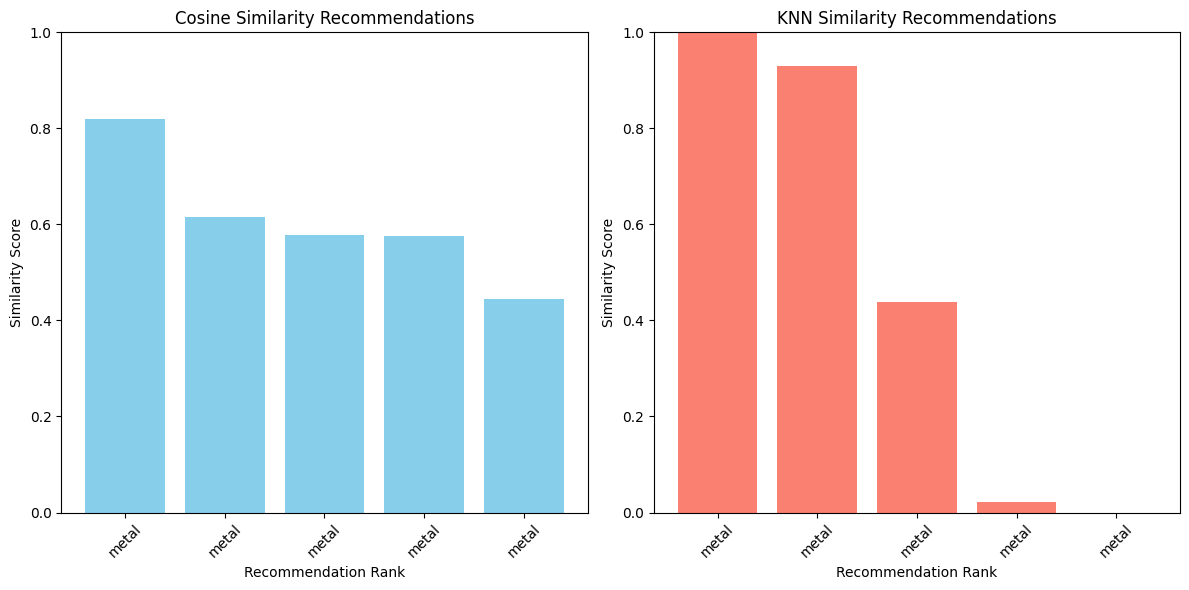

In [22]:
plot_recommendation_comparison(recommendations, knn_reccomendations)

Cosine recommendations:
               file  genre  similarity
57  metal.00098.wav  metal    0.818565
50  metal.00088.wav  metal    0.616213
53  metal.00089.wav  metal    0.578567
32  metal.00097.wav  metal    0.575164
54  metal.00099.wav  metal    0.445112

KNN recommendations:
               file  genre    distance  knn_similarity
59  metal.00070.wav  metal   51.659831        1.000000
48  metal.00074.wav  metal   56.347660        0.930073
50  metal.00088.wav  metal   89.288761        0.438703
43  metal.00093.wav  metal  117.224747        0.021992
57  metal.00098.wav  metal  118.699085        0.000000
Cosine recommendations: 5 songs
KNN recommendations: 5 songs


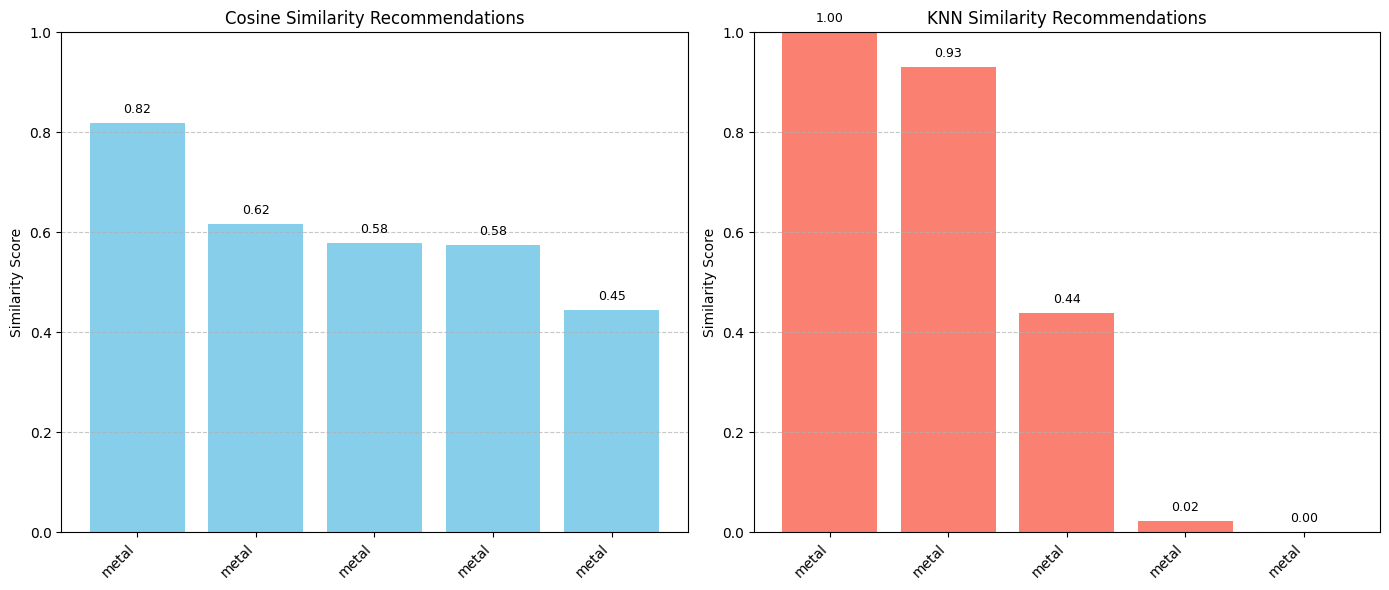

In [23]:
plot_heatmap_comparison(recommendations, knn_reccomendations)

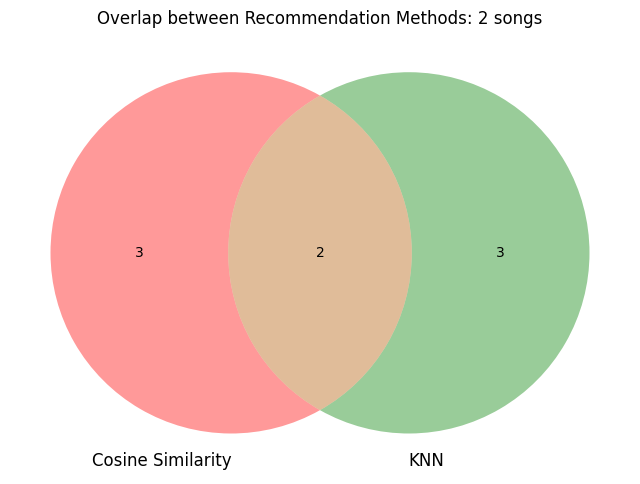

In [24]:
plot_overlap_venn(recommendations, knn_reccomendations)

In [25]:
def evaluate_recommendation_accuracy_cosine(database_path="gtzan_features_database.csv", test_size=0.2):
    # Load database
    database = pd.read_csv(database_path)
    database['features'] = database['features'].apply(eval)
    
    # Split into train/test
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    
    train_db, test_db = train_test_split(database, test_size=test_size, stratify=database['genre'], random_state=42)
    
    # Extract all features for scaling
    all_features = np.array(train_db['features'].tolist())
    
    # Fit scaler on training data
    scaler = StandardScaler()
    scaler.fit(all_features)
    
    # Track metrics
    genre_accuracy = []
    
    # For each test song
    for idx, test_song in test_db.iterrows():
        true_genre = test_song['genre']
        
        # Scale test features
        test_features = np.array(test_song['features'])
        scaled_test_features = scaler.transform([test_features])[0]
        
        # Use all songs from train database
        genre_songs = train_db.copy()
        
        # Calculate similarity to all songs with scaled features
        similarities = []
        for _, song in genre_songs.iterrows():
            song_features = np.array(song['features'])
            scaled_song_features = scaler.transform([song_features])[0]
            sim = cosine_similarity([scaled_test_features], [scaled_song_features])[0][0]
            similarities.append(sim)
        
        genre_songs['similarity'] = similarities
        
        # Get top 5 recommendations
        top_recommendations = genre_songs.sort_values('similarity', ascending=False).head(5)
        
        # Calculate genre match accuracy
        genre_matches = (top_recommendations['genre'] == true_genre).sum()
        accuracy = genre_matches / len(top_recommendations)
        genre_accuracy.append(accuracy)
    
    # Overall accuracy
    mean_accuracy = np.mean(genre_accuracy)
    print(f"Improved Cosine Recommendation accuracy: {mean_accuracy:.2f}")
    
    return mean_accuracy, genre_accuracy

In [26]:
evaluate_recommendation_accuracy_cosine()

Improved Cosine Recommendation accuracy: 0.78


(0.7777777777777778,
 [0.6,
  0.4,
  1.0,
  1.0,
  0.8,
  0.8,
  1.0,
  0.8,
  0.6,
  0.8,
  1.0,
  1.0,
  0.6,
  0.6,
  0.6,
  0.4,
  1.0,
  1.0])

In [15]:
def evaluate_knn_recommendation_accuracy_for_knn(database_path="gtzan_features_database.csv", test_size=0.2, n_neighbors=5):as
    # Load database
    database = pd.read_csv(database_path)
    database['features'] = database['features'].apply(eval)
    
    # Split into train/test
    from sklearn.model_selection import train_test_split
    train_db, test_db = train_test_split(database, test_size=test_size, stratify=database['genre'], random_state=42)
    
    # Track metrics
    genre_accuracy = []
    
    # For each test song
    for idx, test_song in test_db.iterrows():
        true_genre = test_song['genre']
        test_features = np.array(test_song['features'])
        
        # Use entire training database (no pre-filtering)
        genre_songs = train_db.copy()
        features_matrix = np.array(genre_songs['features'].tolist())
        
        # Fit KNN model and find nearest neighbors
        knn = NearestNeighbors(n_neighbors=min(n_neighbors, len(features_matrix)), 
                              algorithm='auto', 
                              metric='euclidean')
        knn.fit(features_matrix)
        
        distances, indices = knn.kneighbors([test_features], n_neighbors=min(n_neighbors, len(features_matrix)))
        
        # Get recommended songs
        top_recommendations = genre_songs.iloc[indices[0]].copy()
        
        # Calculate genre match accuracy
        genre_matches = (top_recommendations['genre'] == true_genre).sum()
        accuracy = genre_matches / len(top_recommendations)
        genre_accuracy.append(accuracy)
    
    # Overall accuracy
    mean_accuracy = np.mean(genre_accuracy)
    print(f"KNN Recommendation accuracy: {mean_accuracy:.2f}")
    
    return mean_accuracy, genre_accuracy

In [18]:
evaluate_knn_recommendation_accuracy_for_knn()

KNN Recommendation accuracy: 0.67


(0.6666666666666665,
 [0.6,
  1.0,
  1.0,
  0.8,
  0.4,
  0.4,
  0.8,
  0.8,
  0.8,
  0.4,
  1.0,
  1.0,
  0.4,
  0.2,
  0.6,
  0.2,
  0.6,
  1.0])